In [1]:
from PPO_train_test import PPO_train, PPO_train_udr, PPO_train_adr, PPO_test

# Hopper Environment

We want to deploy our agent in the real world that is represented by the Target environment, but we have only access to a simulator (source environment) which has a sistematic error wrt real word.

Since we want to close this sim2real gap we will experiment some techniques to address this problem.

To begin with, we will try a simple UDR. Then our focus will be implementing an ADR technique inspired to the OpenAI original paper where ADR is formally introduced in the RL world.

In the following experiment a PPO, policy-based RL algorithm, will be employed.

Nota:
- In Target, l'hopper ha un torso più pesante. La massa elevata conferisce inerzia. L'inerzia agisce come un "filtro passa-basso" naturale: smorza le oscillazioni e rende il robot più stabile contro piccoli errori di controllo o rumore nelle azioni.

- In Source, l'hopper ha un torso molto più leggero. Con meno inerzia, il robot diventa "nervoso" (twitchy). Ogni piccola forza applicata dai motori si traduce in un'accelerazione angolare molto più rapida (F=m⋅a→a=F/m; se m scende, a sale). Questo rende molto più facile per il robot perdere l'equilibrio e cadere (terminando l'episodio prima dei 500 step).

I motori (attuatori) dell'Hopper hanno la stessa forza massima in entrambi gli ambienti, ma nel Source devono spingere meno massa.
Nel caso Source, il robot è "sovra-potenziato" rispetto al suo peso. Questo rende il paesaggio di ottimizzazione (la "superficie" che l'algoritmo PPO deve scalare) molto più frastagliato. Un'azione leggermente sbagliata nel Source porta a conseguenze catastrofiche (caduta) molto più velocemente che nel Target.
L'ambiente Hopper-v* standard di Gym (che corrisponde al tuo Target) è stato progettato e sintonizzato dai creatori di MuJoCo per avere proprietà fisiche che rendono la locomozione apprendibile e stabile. Modificando arbitrariamente una massa fondamentale come quella del torso (togliendo 1kg, che è una percentuale significativa del peso totale), si crea un robot "sbilanciato" o fisicamente meno adatto alla locomozione rispetto al design originale.

Per questo motivo, mentre target->target arriva sempre a 500 timesteps medi (con std=0) per episodio in test, source->source non ci riesce mai.

In [2]:
TIMESTEPS = 1_500_000
SEED = 3377

To begin with, lets train PPO on source and test on source:

Output()


--- Training on CustomHopper-source-v0 ---


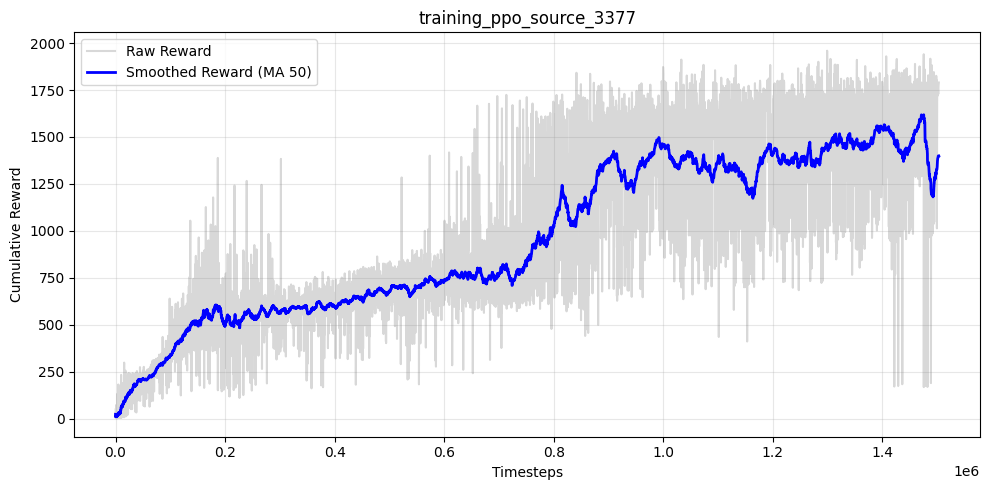

In [5]:
PPO_train(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_{SEED}',
    lr=3e-4,
    steps=TIMESTEPS,
    seed=SEED
)

In [6]:
mean, std = PPO_test(
    test_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_{SEED}'
)

--- Testing on CustomHopper-source-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 1675.82 +/- 77.75
  Mean Steps:  454.88 +/- 34.50


Now, lets test it on target:

In [7]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_source_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---
Test Results:
  Mean Reward: 874.02 +/- 10.53
  Mean Steps:  226.06 +/- 1.94


Now we train PPO on target and test it on target

Output()


--- Training on CustomHopper-target-v0 ---


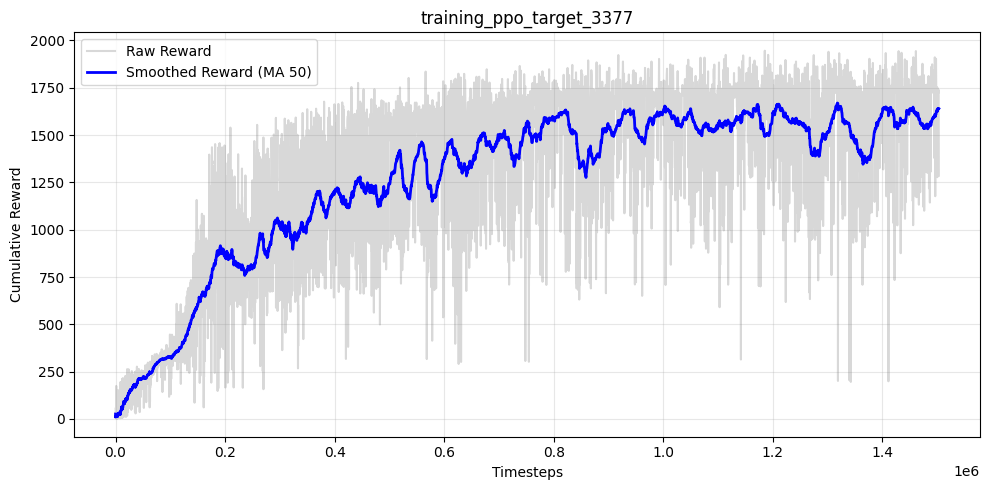

In [8]:
PPO_train(
    train_env_id='CustomHopper-target-v0',
    model_name=f'ppo_target_{SEED}',
    lr=3e-4,
    steps=TIMESTEPS,
    seed=SEED
)

In [9]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_target_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 1727.21 +/- 3.29
  Mean Steps:  500.00 +/- 0.00


## UDR

Lets use UDR:


--- Training on CustomHopper-source-v0 using UDR ---


Output()

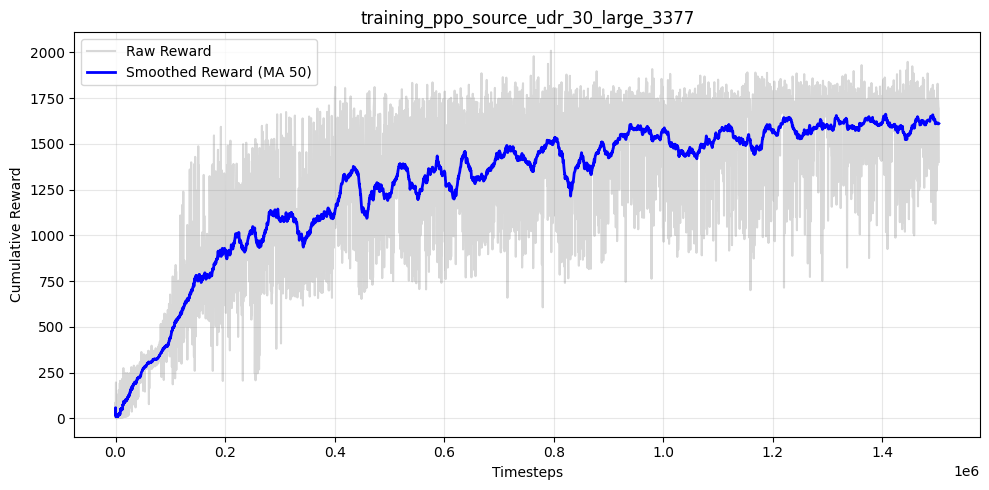

In [3]:
PPO_train_udr(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_udr_30_large_{SEED}',
    lr=3e-4,
    lr_scheduler_type='linear',
    steps=TIMESTEPS,
    udr_range=0.3,
    net_size="large", # [ small - medium - large ] -> [ 64 - 128 - 256 ],
    seed=SEED
)

In [4]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_source_udr_30_large_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 1161.43 +/- 88.42
  Mean Steps:  314.28 +/- 20.16


## ADR

Now, lets get serious and use Automatic Domain Randomization (OpenAI style, that is testing the borders before enlarging the distribution range):


--- Training on CustomHopper-source-v0 using ADR ---


Output()

/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 309.73 +/- 1.5149230463618413

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 862.56 +/- 24.19502080584166

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1291.17 +/- 149.3386691672566

[ADR Boundary Test] Range +/- 5.0% -> Reward: 812.30 +/- 109.26537085809298

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1125.00 +/- 240.52360216581758

[ADR Boundary Test] Range +/- 5.0% -> Reward: 983.96 +/- 154.9871407156101

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1470.26 +/- 79.07114531558523

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1305.44 +/- 250.1830450840865

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1529.92 +/- 37.221419404178846

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1281.82 +/- 229.00607216857082

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1656.22 +/- 168.29981511857892

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1477.03 +/- 260.8027928623123

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1333.44 +/- 143.70079877331966

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1239.77 +/- 399.13765192439945

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1615.95 +/- 174.2222164061375

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1432.18 +/- 334.64342738753606

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1252.70 +/- 373.1669598834891

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1454.67 +/- 252.65144554775082

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1405.68 +/- 321.14737347008514

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1459.31 +/- 270.4541369825736

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1603.81 +/- 198.0394943813592

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1630.68 +/- 202.70985310479875

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1635.98 +/- 261.3199393530569

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1659.64 +/- 178.11383508872436

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1552.17 +/- 241.61413936044144

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1536.59 +/- 301.8823170257135

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1682.08 +/- 128.54978362451791

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1644.33 +/- 227.16190811964432

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1685.49 +/- 154.67069851894146

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1358.54 +/- 377.8979906464601

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1407.13 +/- 357.1274317732686

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1460.28 +/- 325.46475911242635

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1500.41 +/- 332.66072779548017

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1552.64 +/- 257.50328935901416

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1511.36 +/- 256.64219187981865

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1466.37 +/- 305.58524820857633

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1469.12 +/- 247.82575809403139

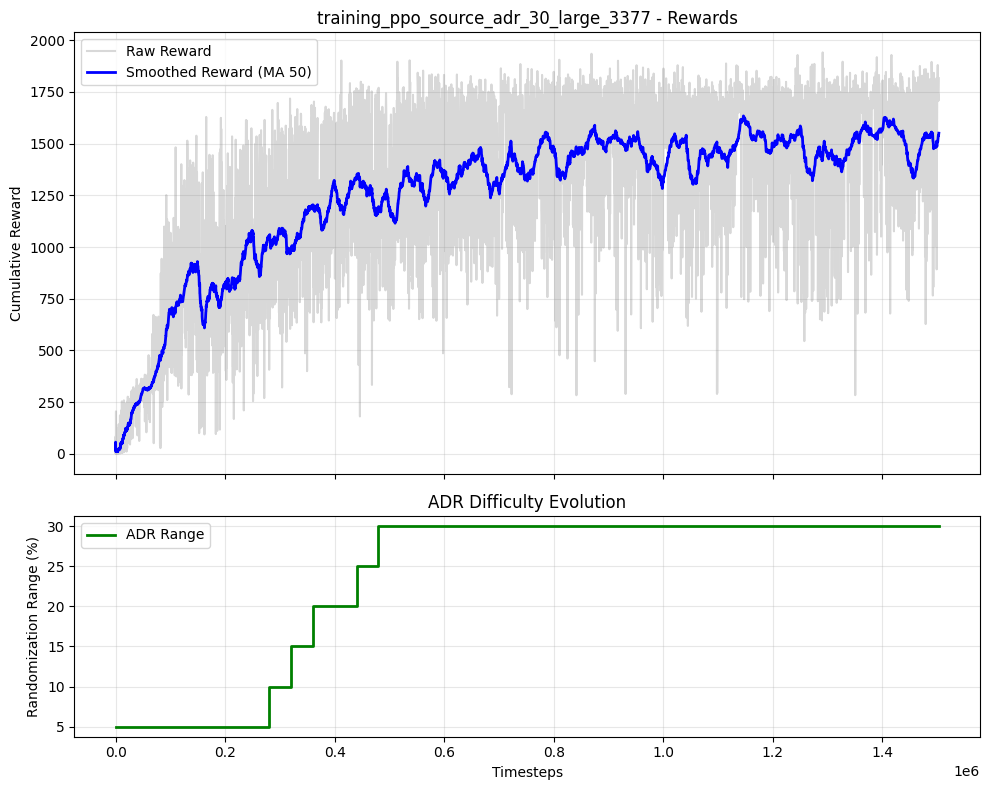

In [ ]:
PPO_train_adr(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_adr_30_large_{SEED}',
    lr=3e-4,
    lr_scheduler_type="constant",
    steps=TIMESTEPS,
    starting_adr_range=0.05,
    objective_adr_range=0.3,
    increase_rate=0.05,
    reward_to_check=1300,
    check_frequency=40_000,
    net_size="large",
    seed=SEED
)

In [4]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_source_adr_30_large_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 1707.85 +/- 120.94
  Mean Steps:  472.32 +/- 41.51


## Visualization

In [ ]:
from utils.visualize_agent import visualize

model = f"ppo_source_adr_30_medium_{SEED}"

visualize(
    model_path=f"models/{model}",
    env_id="CustomHopper-target-v0"
)